### Data

In [238]:
# Import the necessary packages
import sys
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import itertools

In [239]:
# Import the CORA dataset
import dgl.data
dataset = dgl.data.CoraGraphDataset()       # Nodes: 2708 Edges: 10556
#dataset = dgl.data.CiteseerGraphDataset()   # Nodes: 3327 Edges: 9228
#dataset = dgl.data.PubmedGraphDataset()     # Nodes: 19717 Edges: 88651
#dataset = dgl.data.CoraFullDataset()        # Nodes: 19,793 Edges: 130,622
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


### Edge Detection

In [240]:
from dgl.nn import SAGEConv

# ----------- 2. Create Model -------------- #
# Build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
    
# Data selection and generating positive and negative graphs
def data_select(factor):
    # Split edge set for training and testing 90:10
    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = g.number_of_edges() - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    neg_eids = np.random.choice(len(neg_u), g.number_of_edges() // factor)
    test_size = int(len(neg_eids) * 0.1)
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    # Remove the edges in the test set from the original graph
    train_g = dgl.remove_edges(g, eids[:test_size])

    # Construct the positive and negative graphs for training and testing sets
    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

    print("Train Set - Positive Edges: ",len(train_pos_u))
    print("Train Set - Negative Edges: ",len(train_neg_u))
    print("Test Set - Positive Edges: ", len(test_pos_u))
    print("Test Set - Negative Edges: ",len(test_neg_u),'\n')
    
    # Returns the training/testing graphs
    return train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g

In [241]:
train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = data_select(2)

Train Set - Positive Edges:  9501
Train Set - Negative Edges:  4751
Test Set - Positive Edges:  1055
Test Set - Negative Edges:  527 



In [242]:
import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

In [243]:
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(self.apply_edges)
            return g.edata['score']

In [244]:
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16)
# You can replace DotPredictor with MLPPredictor.
#pred = MLPPredictor(16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_weighted_loss(pos_score, neg_score, weight=None):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels, pos_weight=weight)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

def compute_prc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return average_precision_score(labels, scores, pos_label=0), average_precision_score(labels, scores, pos_label=1)

Train Set - Positive Edges:  9501
Train Set - Negative Edges:  9501
Test Set - Positive Edges:  1055
Test Set - Negative Edges:  1055 

In epoch 0, loss: 0.7320640087127686
In epoch 5, loss: 0.6922084093093872
In epoch 10, loss: 0.6623343229293823
In epoch 15, loss: 0.5970226526260376
In epoch 20, loss: 0.5360862612724304
In epoch 25, loss: 0.4933178424835205
In epoch 30, loss: 0.47022321820259094
In epoch 35, loss: 0.4545938968658447
In epoch 40, loss: 0.43325358629226685
In epoch 45, loss: 0.415857195854187
In epoch 50, loss: 0.3988702893257141
In epoch 55, loss: 0.38268548250198364
In epoch 60, loss: 0.3666316270828247
In epoch 65, loss: 0.3503594696521759
In epoch 70, loss: 0.3342951834201813
In epoch 75, loss: 0.31816110014915466
In epoch 80, loss: 0.30208924412727356
In epoch 85, loss: 0.2862562835216522
In epoch 90, loss: 0.2702898681163788
In epoch 95, loss: 0.25476762652397156
AUC 0.8464607713213989
Minority PR_AUC 0.33599570836487985
Majority PR_AUC 0.7937551335795002

******

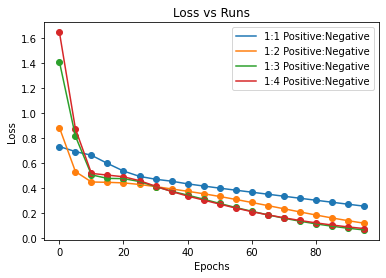

In [245]:
# ----------- 3. Set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

# ----------- 4. Training -------------------------------- #
factors = [1,2,3,4]   # Factor to imbalance the data
auc_scores = []       # Keep track of the AUC values
min_pr_scores = []
maj_pr_scores = []
fig = plt.figure()
for i in range(len(factors)):
    train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = data_select(factors[i])

    all_logits = []
    epochs = []
    lossvals = []
    for e in range(100):
        # forward
        h = model(train_g, train_g.ndata['feat'])
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        
        #imb_weight = torch.cat([0*torch.ones(pos_score.shape[0]), 
        #                        1*torch.ones(neg_score.shape[0])])   # 15% drop AUC, 15% increase PR-min
        #imb_weight = torch.cat([0*torch.ones(pos_score.shape[0]), 
        #                        0.5*torch.ones(neg_score.shape[0])])  # 25% drop AUC, 20% increase PR-min
        imb_weight = torch.cat([0*torch.ones(pos_score.shape[0]), 
                                1/factors[i]*torch.ones(neg_score.shape[0])])
        
        imbalance = train_neg_g.number_of_edges()/train_pos_g.number_of_edges()
        sig_q = 1-imbalance
        sigmoid = 1/(1+np.exp(-sig_q))
        imb_sig = torch.cat([0*torch.ones(pos_score.shape[0]), sigmoid*torch.ones(neg_score.shape[0])]) 
        
        # If the imbalance is less than 20% use the original loss function
        if (imbalance > 0.8):
            loss = compute_weighted_loss(pos_score, neg_score)   # no weights
        else: 
            loss = compute_weighted_loss(pos_score, neg_score, imb_weight)*factors[i]
                
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if e % 5 == 0:
            epochs.append(e)
            lossvals.append(loss.item())
            print('In epoch {}, loss: {}'.format(e, loss))

    # ----------- 5. Check Results ------------------------ #
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import average_precision_score
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        auc = compute_auc(pos_score, neg_score)
        minor_pr_auc, major_pr_auc = compute_prc(pos_score, neg_score)
        auc_scores.insert(len(auc_scores), auc)
        min_pr_scores.insert(len(min_pr_scores), minor_pr_auc)
        maj_pr_scores.insert(len(maj_pr_scores), major_pr_auc)
        print('AUC', auc)
        print('Minority PR_AUC', minor_pr_auc)
        print('Majority PR_AUC', major_pr_auc)
        print('\n*****************************************\n')
        
    # Plot
    plt.scatter(epochs, lossvals)
    plt.plot(epochs, lossvals, label='1:{} Positive:Negative'.format(factors[i]))

# Plot labels
plt.legend()
plt.title("Loss vs Runs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

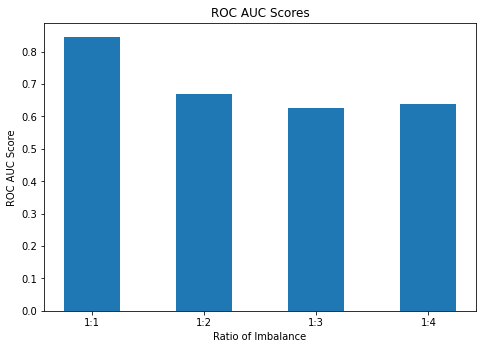

In [246]:
fig = plt.figure()
ratios = []
for k in range(len(factors)):
    ratios.append('1:{}'.format(factors[k]))
ax = fig.add_axes([0,0,1,1])
ax.bar(ratios, auc_scores, 0.5)
plt.title("ROC AUC Scores")
plt.xlabel("Ratio of Imbalance")
plt.ylabel("ROC AUC Score")
plt.show()

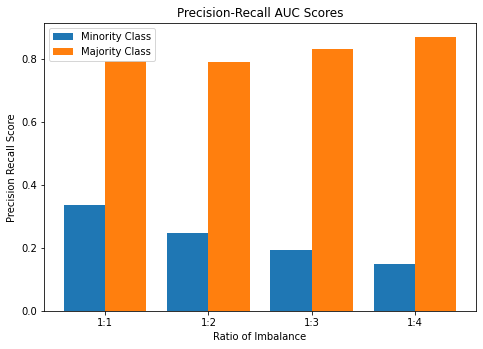

In [247]:
fig, ax = plt.subplots()
ax = fig.add_axes([0,0,1,1])
ratios = []
for k in range(len(factors)):
    ratios.append('1:{}'.format(factors[k]))
x_axis = np.arange(len(ratios))
bars1 = ax.bar(x_axis - 0.2, min_pr_scores, 0.4, label = 'Minority Class')
bars2 = ax.bar(x_axis + 0.2, maj_pr_scores, 0.4, label = 'Majority Class')
ax.set_xticks(x_axis)
ax.set_xticklabels(ratios)
plt.title("Precision-Recall AUC Scores")
plt.xlabel("Ratio of Imbalance")
plt.ylabel("Precision Recall Score")
plt.legend()
plt.show()

In [248]:
# Original scores
auc_org = [0.8429648929718562, 0.8602714101999155, 0.8804012908278311, 0.9014181968896978]
maj_pr_org = [0.8147503304995518, 0.9066036877657693, 0.9391281440037891, 0.9621504449192085]
min_pr_org = [0.33302690139182634, 0.203405367764602, 0.144266888257322, 0.11129830080077503]

# New scores
print('AUC Scores:             ', auc_scores)
print('Majority PR Scores:     ', maj_pr_scores)
print('Minority PR Scores:     ', min_pr_scores,'\n')

# Change
delta_auc = [auc_scores[i]/auc_org[i] for i in range(len(auc_scores))]
delta_pr_maj = [maj_pr_scores[i]/maj_pr_org[i] for i in range(len(maj_pr_scores))]
delta_pr_min = [min_pr_scores[i]/min_pr_org[i] for i in range(len(min_pr_scores))]

print('Average Change AUC:      {} %'.format((sum(delta_auc)/len(delta_auc)-1)*100))
print('Average Change PR-Maj:   {} %'.format((sum(delta_pr_maj)/len(delta_pr_maj)-1)*100))
print('Average Change PR-Min:   {} %'.format((sum(delta_pr_min)/len(delta_pr_min)-1)*100))

AUC Scores:              [0.8464607713213989, 0.6684245078554278, 0.6260487976127787, 0.6380083974555348]
Majority PR Scores:      [0.7937551335795002, 0.7890044093354007, 0.8320560837316255, 0.8715607217807346]
Minority PR Scores:      [0.33599570836487985, 0.24808767616630611, 0.19180855279271974, 0.14924441091179716] 

Average Change AUC:      -19.999563955243804 %
Average Change PR-Maj:   -9.09121374287054 %
Average Change PR-Min:   22.47665349176957 %
